In [48]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import regex as re

In [49]:
comp_data_folder = "kompressordaten"
power_consumption_file = comp_data_folder + "/StromverbrauchKompressoren_09112023.csv"
air_flow_net_file = comp_data_folder + "/DurchflussDatenNetzABC_Kombrimiert15minTakt_09112023-1.csv"
air_flow_net_precise_file = comp_data_folder + "/DurchflussDatenNetzABC_09112023-3.csv"
air_leader_file = comp_data_folder + "/AirLeader_20231109_log.csv"

compressor_list_file = comp_data_folder + "/compressor_list.csv"

## Power Consumption

In [3]:
power_consumption = pd.read_table(power_consumption_file, sep=",", usecols=[1,5,6])

# Convert the 'Datum' column to datetime format
power_consumption['Datum'] = pd.to_datetime(power_consumption['Datum'], format='%d.%m.%Y %H:%M:%S')
# Convert the datetime values to seconds via a reference date and write into new series
reference_date = pd.to_datetime('2023-11-09')
power_consumption['seconds'] = (power_consumption['Datum']-reference_date).dt.total_seconds()
# Drop the 'Datum' column
power_consumption = power_consumption.drop(columns=['Datum'])
# Rearrange for seconds series to lead
power_consumption = power_consumption[['seconds','Nummer','Wert']]

power_consumption.head()

,seconds,Nummer,Wert
0,300.0,25600,0.0
1,600.0,25600,0.0
2,900.0,25600,0.0
3,1200.0,25600,0.0
4,1500.0,25600,0.0


In [4]:
#specify number of rows of compressors
n = len(power_consumption['Nummer'].unique())
#split dataframe into array of dataframes
power_consumption_split = np.array_split(power_consumption, n)

C:\Users\jnicklau\AppData\Local\miniforge3\envs\aps\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [5]:
seconds = power_consumption_split[0]['seconds']
power_consumption = pd.DataFrame(data = seconds)
for df in power_consumption_split:
    name_string = df['Nummer'].unique()[0]
    val = df['Wert']
    power_consumption['%s' %name_string] = val.reset_index(drop=True)

In [6]:
power_consumption.head()

,seconds,25600,26600,26700,27100,27200,27300,27500,27600,27700,27800,28000,28200,28300,27195
0,300.0,0.0,23.0,0.0,0.0,7.0,0.0,24.0,13.0,0.0,14.0,10.0,0.0,20.0,58.0
1,600.0,0.0,22.0,0.0,0.0,1.0,0.0,23.0,13.0,0.0,14.0,6.0,0.0,21.0,53.0
2,900.0,0.0,22.0,0.0,0.0,5.0,0.0,24.0,15.0,0.0,16.0,19.0,0.0,21.0,59.0
3,1200.0,0.0,23.0,0.0,0.0,1.0,0.0,24.0,7.0,0.0,15.0,22.0,0.0,20.0,47.0
4,1500.0,0.0,22.0,0.0,0.0,0.0,0.0,23.0,5.0,0.0,11.0,21.0,0.0,19.0,39.0


In [7]:
power_consumption.describe()

,seconds,25600,26600,26700,27100,27200,27300,27500,27600,27700,27800,28000,28200,28300,27195
count,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.0,288.000000,288.000000
mean,43350.000000,0.545139,21.684028,0.892361,1.100694,5.493056,1.777778,23.413194,10.479167,1.534722,12.906250,17.996528,0.0,20.024306,55.732639
std,24984.795376,1.273440,3.087711,2.296538,3.689178,3.189697,2.851601,0.553197,3.497074,3.431588,3.096851,6.589770,0.0,2.366159,8.649669
min,300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,4.000000,0.000000,0.000000,0.000000,0.0,7.000000,32.000000
25%,21825.000000,0.000000,22.000000,0.000000,0.000000,2.000000,0.000000,23.000000,8.000000,0.000000,11.000000,20.000000,0.0,20.000000,50.000000
50%,43350.000000,0.000000,22.000000,0.000000,0.000000,8.000000,0.000000,23.000000,10.500000,0.000000,14.000000,21.000000,0.0,21.000000,56.000000
75%,64875.000000,0.000000,23.000000,0.000000,0.000000,8.000000,3.000000,24.000000,13.000000,0.000000,15.000000,21.000000,0.0,21.000000,63.000000
max,86400.000000,4.000000,23.000000,10.000000,19.000000,9.000000,10.000000,25.000000,16.000000,12.000000,16.000000,22.000000,0.0,22.000000,82.000000


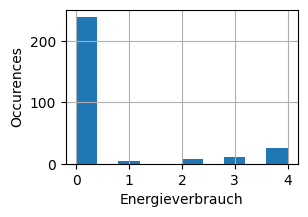

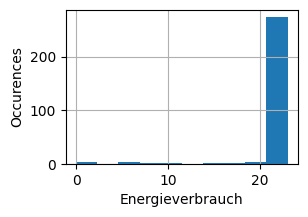

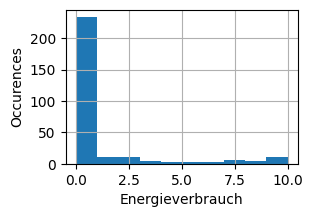

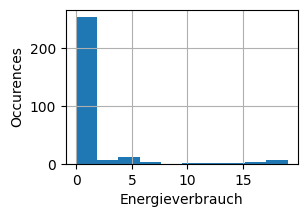

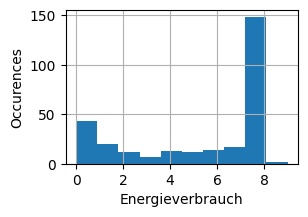

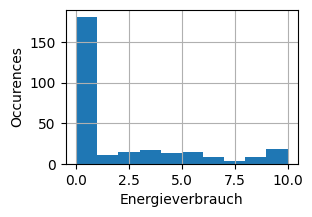

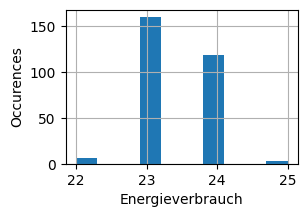

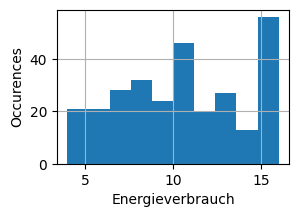

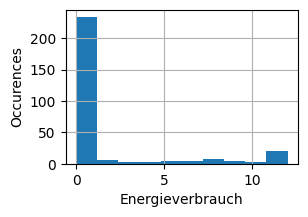

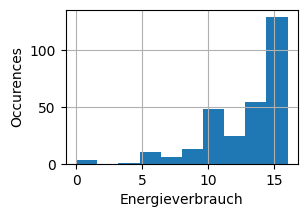

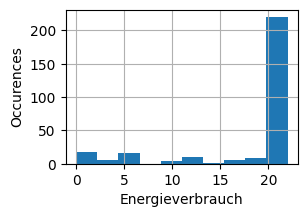

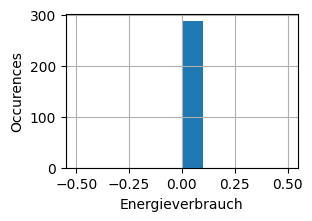

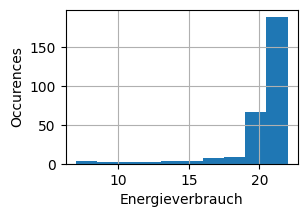

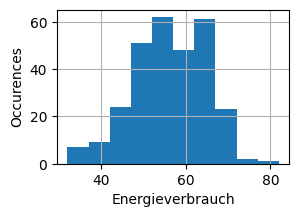

In [8]:
for c in power_consumption.columns[1:]:
    power_consumption[c].hist(figsize=(3,2))
    plt.ylabel('Occurences')
    plt.xlabel('Energieverbrauch')
    plt.show()

## Air Flow Net

### reading file

In [9]:
air_flow_net = pd.read_table(air_flow_net_file, sep=";", usecols=[0,1,2,3,4,5])
# rename 'Sps_datum' column
air_flow_net['Datum'] = air_flow_net['Sps_datum'] 
air_flow_net = air_flow_net.drop(columns=['Sps_datum'])

# Convert the 'Datum' column to datetime format
air_flow_net['Datum'] = pd.to_datetime(air_flow_net['Datum'], format='%d.%m.%Y %H:%M')

# Convert the datetime values to seconds via a reference date and write into new series
reference_date = pd.to_datetime('2023-11-09')
air_flow_net['seconds'] = (air_flow_net['Datum']-reference_date).dt.total_seconds()

# Drop the 'Datum' column
air_flow_net = air_flow_net.drop(columns=['Datum'])

# replace ',' by '.'
air_flow_net.replace(',', '.', regex=True, inplace=True)
air_flow_net.replace(' [cm/min]', '', regex=True, inplace=True)

# Rearrange for seconds series to lead and give series more informative names
new_air_flow_net = pd.DataFrame()
for i in range(len(air_flow_net.columns)):
    oldname = '%s' %air_flow_net.columns[i-1]
    patterns_to_replace = ['Trocknung-Durchfluss ', ' [cm/min]']
    replacement = ''
    pattern = re.compile('|'.join(map(re.escape, patterns_to_replace)))
    newname = pattern.sub(replacement, oldname, count=0)
    new_air_flow_net[newname] = air_flow_net[oldname].astype(float)
air_flow_net = new_air_flow_net

# drop first column (700.1) since no values are currently available
air_flow_net = air_flow_net.drop('7A Netz 700.1',axis=1)


### evaluating file

In [10]:
air_flow_net.head()

,seconds,7B Netz 800.1,7A Netz 700.5,7A Netz 700.6,7C Netz 900.1
0,420.0,39.23,39.02,69.57,28.95
1,1320.0,53.97,42.65,80.72,19.10
2,2220.0,45.64,40.62,73.60,31.54
3,3120.0,94.18,43.67,81.68,25.67
4,4020.0,77.88,46.68,86.78,30.06


In [11]:
air_flow_net.describe()

,seconds,7B Netz 800.1,7A Netz 700.5,7A Netz 700.6,7C Netz 900.1
count,96.000000,96.000000,96.000000,96.000000,96.000000
mean,43170.000000,70.124479,45.330208,84.283854,26.584271
std,25071.098899,20.641962,5.399862,13.328171,10.013228
min,420.000000,15.900000,30.200000,48.680000,9.740000
25%,21795.000000,57.820000,43.257500,77.677500,19.565000
50%,43170.000000,73.500000,46.270000,86.820000,25.725000
75%,64545.000000,86.772500,48.197500,92.415000,31.170000
max,85920.000000,101.000000,65.870000,120.120000,59.270000


7B Netz 800.1


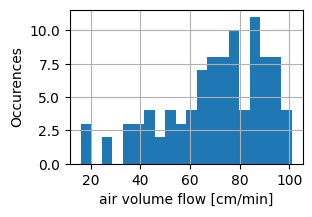

7A Netz 700.5


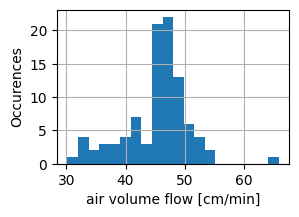

7A Netz 700.6


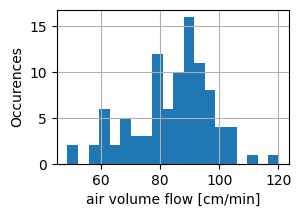

7C Netz 900.1


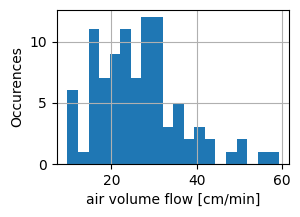

In [12]:
for c in air_flow_net.columns[1:]:
    print(c)
    air_flow_net[c].hist(bins = 20,figsize = (3,2))
    plt.xlabel('air volume flow [cm/min]')
    plt.ylabel('Occurences')
    plt.show()

### getting seconds interpolated


## Plotting times series

In [13]:
def timeseries_plot(df,**kwargs):
    df.plot(x=0, y=range(1,len(df.columns)), **kwargs)
    plt.show()

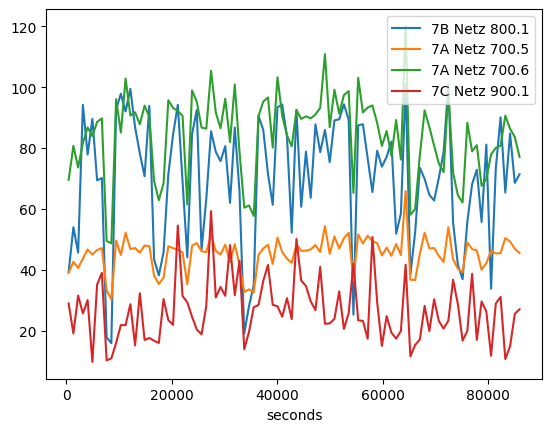

In [14]:
timeseries_plot(air_flow_net)

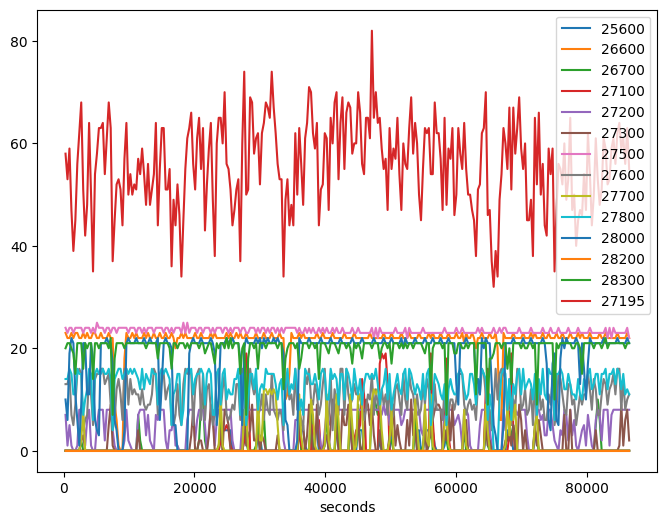

In [15]:
timeseries_plot(power_consumption,figsize=(8,6))

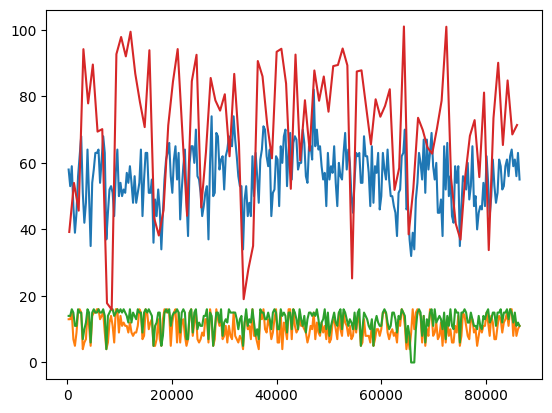

In [16]:
power_consumption_ys = [power_consumption['27195'], power_consumption['27600'], power_consumption['27800']]
air_flow_net_ys = [air_flow_net['7B Netz 800.1']]
ys = power_consumption_ys + air_flow_net_ys
power_consumption_xs = [power_consumption['seconds'].values]*len(power_consumption_ys)
air_flow_net_xs = [air_flow_net['seconds'].values]*len(air_flow_net_ys)
xs = power_consumption_xs + air_flow_net_xs

fig, ax = plt.subplots()
for x,y in zip(xs,ys,):
    ax.plot(x,y)
plt.show()

## Air Flow Net Precise


Is the precise dataset better than the dataset with air flow values every 15 minutes?

In [17]:
air_flow_net_precise = pd.read_table(air_flow_net_precise_file, sep=";", usecols=[0,1,2,3,4,5])
# rename 'Sps_datum' column
air_flow_net_precise['Datum'] = air_flow_net_precise['Sps_datum'] 
air_flow_net_precise = air_flow_net_precise.drop(columns=['Sps_datum'])

# Convert the 'Datum' column to datetime format
air_flow_net_precise['Datum'] = pd.to_datetime(air_flow_net_precise['Datum'], format='%d.%m.%Y %H:%M')

# Convert the datetime values to seconds via a reference date and write into new series
reference_date = pd.to_datetime('2023-11-09')
air_flow_net_precise['seconds'] = (air_flow_net_precise['Datum']-reference_date).dt.total_seconds()

# Drop the 'Datum' column
air_flow_net_precise = air_flow_net_precise.drop(columns=['Datum'])

# replace ',' by '.'
air_flow_net_precise.replace(',', '.', regex=True, inplace=True)
air_flow_net_precise.replace(' [cm/min]', '', regex=True, inplace=True)

# Rearrange for seconds series to lead 
new_air_flow_net_precise = pd.DataFrame()
for i in range(len(air_flow_net_precise.columns)):
    oldname = '%s' %air_flow_net_precise.columns[i-1]
    patterns_to_replace = ['Trocknung-Durchfluss ', ' [cm/min]']
    replacement = ''
    pattern = re.compile('|'.join(map(re.escape, patterns_to_replace)))
    newname = pattern.sub(replacement, oldname, count=0)
    print(newname)
    new_air_flow_net_precise[newname] = air_flow_net_precise[oldname].astype(float)
air_flow_net_precise = new_air_flow_net_precise

# drop first column (700.1) since no values are currently available
air_flow_net_precise = air_flow_net_precise.drop('7A Netz 700.1',axis=1)
air_flow_net_precise.head(60)

seconds
7A Netz 700.1
7B Netz 800.1
7A Netz 700.5
7A Netz 700.6
7C Netz 900.1


,seconds,7B Netz 800.1,7A Netz 700.5,7A Netz 700.6,7C Netz 900.1
0,0.0,59.50,NaN,NaN,NaN
1,0.0,66.99,42.22,74.98,NaN
2,0.0,59.50,NaN,NaN,NaN
3,0.0,81.02,43.80,77.21,NaN
4,0.0,66.99,NaN,NaN,NaN
5,0.0,84.20,NaN,NaN,NaN
6,0.0,81.02,NaN,NaN,NaN
7,0.0,80.39,42.47,NaN,NaN
8,0.0,84.20,NaN,NaN,NaN
9,0.0,76.56,NaN,78.28,NaN


In [18]:
air_flow_net_precise.groupby('seconds').count()

,7B Netz 800.1,7A Netz 700.5,7A Netz 700.6,7C Netz 900.1
seconds,,,,
0.0,52,7,11,2
60.0,43,9,9,2
120.0,42,6,13,6
180.0,35,2,9,2
240.0,36,9,17,8
...,...,...,...,...
86100.0,33,5,9,1
86160.0,38,8,12,2
86220.0,35,6,10,5


In [19]:
air_flow_net_precise.describe()

,seconds,7B Netz 800.1,7A Netz 700.5,7A Netz 700.6,7C Netz 900.1
count,58884.000000,55335.000000,8511.000000,13637.000000,6122.000000
mean,43538.688608,73.951111,46.293884,85.701553,26.509997
std,24940.407510,17.765027,6.149859,13.269880,8.992199
min,0.000000,9.380000,24.550000,32.970000,4.520000
25%,21900.000000,63.480000,43.365000,78.270000,19.715000
50%,43980.000000,77.160000,46.690000,87.210000,25.115000
75%,65220.000000,87.000000,49.480000,94.110000,32.127500
max,86340.000000,117.870000,93.350000,129.470000,59.270000


In [20]:
air_flow_net_precise[air_flow_net_precise['%s' %air_flow_net_precise.columns[1]].isnull()]


,seconds,7B Netz 800.1,7A Netz 700.5,7A Netz 700.6,7C Netz 900.1
59,60.0,NaN,44.78,NaN,NaN
103,120.0,NaN,45.43,NaN,NaN
117,120.0,NaN,46.46,87.02,12.83
119,120.0,NaN,NaN,91.68,14.37
130,120.0,NaN,NaN,96.35,NaN
...,...,...,...,...,...
58738,86160.0,NaN,NaN,NaN,23.57
58748,86160.0,NaN,45.62,NaN,NaN
58763,86160.0,NaN,NaN,87.09,NaN
58772,86220.0,NaN,52.33,NaN,NaN


In [21]:
air_flow_net_precise[air_flow_net_precise['%s' %air_flow_net_precise.columns[1]].isnull()].count()

seconds          3549
7B Netz 800.1       0
7A Netz 700.5    1470
7A Netz 700.6    1719
7C Netz 900.1    1140
dtype: int64

In [22]:
for i in range(len(air_flow_net_precise.columns)):
    print(air_flow_net_precise[air_flow_net_precise['%s' %air_flow_net_precise.columns[i] ].isnull()].count())

seconds          0
7B Netz 800.1    0
7A Netz 700.5    0
7A Netz 700.6    0
7C Netz 900.1    0
dtype: int64
seconds          3549
7B Netz 800.1       0
7A Netz 700.5    1470
7A Netz 700.6    1719
7C Netz 900.1    1140
dtype: int64
seconds          50373
7B Netz 800.1    48294
7A Netz 700.5        0
7A Netz 700.6    10036
7C Netz 900.1     4807
dtype: int64
seconds          45247
7B Netz 800.1    43417
7A Netz 700.5     4910
7A Netz 700.6        0
7C Netz 900.1     4040
dtype: int64
seconds          52762
7B Netz 800.1    50353
7A Netz 700.5     7196
7A Netz 700.6    11555
7C Netz 900.1        0
dtype: int64


### get a full precise air_flow dataframe 
Drop all rows where any column has NaN
 

In [23]:
# Drop rows where any column has NaN
air_flow_net_precise_full = air_flow_net_precise.dropna()
air_flow_net_precise_full.count()

seconds          584
7B Netz 800.1    584
7A Netz 700.5    584
7A Netz 700.6    584
7C Netz 900.1    584
dtype: int64

In [24]:
precise_full_seconds = air_flow_net_precise_full['seconds']
differences = precise_full_seconds.diff()
max_difference = differences.max()
print('Maximum difference: %s' %{max_difference})

Maximum difference: {900.0}


<Axes: >

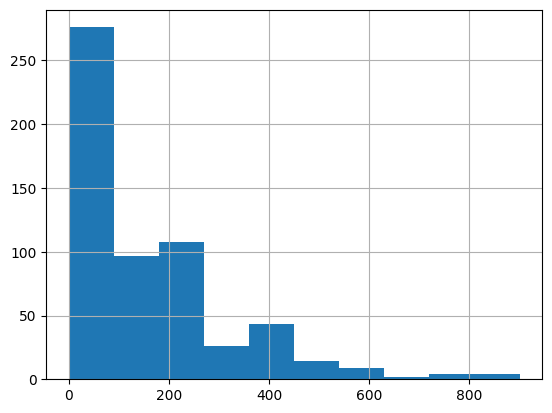

In [25]:
differences.hist()

In [26]:
differences.value_counts()

seconds
60.0     145
0.0      131
120.0     97
180.0     69
240.0     39
300.0     26
360.0     24
420.0     19
480.0     14
540.0      5
720.0      4
600.0      4
660.0      2
900.0      2
840.0      2
Name: count, dtype: int64

In [27]:
differences[differences > 480]

1519     540.0
4035     660.0
5558     900.0
8974     540.0
9779     720.0
10399    720.0
14740    600.0
23453    600.0
25891    720.0
27083    600.0
32904    840.0
33460    540.0
34670    660.0
38937    540.0
44736    840.0
45380    720.0
53672    600.0
54620    540.0
57311    900.0
Name: seconds, dtype: float64

In [28]:
precise_full_seconds.describe()

count      584.000000
mean     43031.198630
std      25026.458396
min        120.000000
25%      22635.000000
50%      43350.000000
75%      65070.000000
max      86160.000000
Name: seconds, dtype: float64

In [29]:
precise_full_seconds.tail()

57982    85080.0
58255    85440.0
58591    85920.0
58601    85920.0
58743    86160.0
Name: seconds, dtype: float64

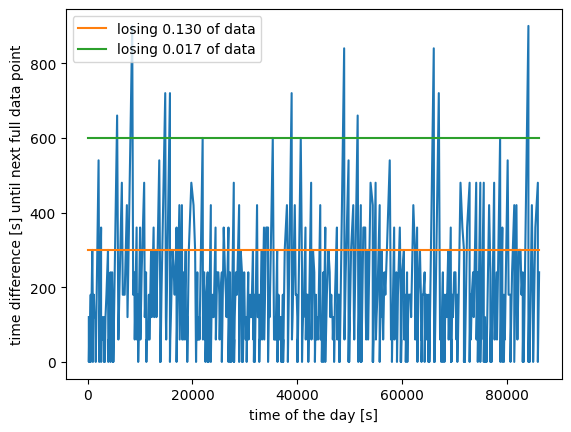

In [30]:
plt.plot(precise_full_seconds,differences)
above300rate = len(differences[differences > 300])/584
label300 = 'losing %.3f of data' %(above300rate)
plt.plot(precise_full_seconds, [300]*len(precise_full_seconds), label = label300)
above600rate = len(differences[differences > 600])/584
label600 = 'losing %.3f of data' %(above600rate)
plt.plot(precise_full_seconds, [600]*len(precise_full_seconds), label = label600)
plt.xlabel('time of the day [s]')
plt.ylabel('time difference [s] until next full data point')

plt.legend()

What if we mesh both together?

### try a different approach
seperate columns and then drop NAN values to see if there exists a constant ratio of measurements/minute

In [31]:
for c in air_flow_net_precise.columns[1:]:
    df = pd.DataFrame(data=air_flow_net_precise['seconds'])
    df[c] = air_flow_net_precise[c]
    df = df.dropna()
    print(df.groupby('seconds').count().describe())


       7B Netz 800.1
count    1440.000000
mean       38.427083
std         7.516595
min         7.000000
25%        36.000000
50%        40.000000
75%        43.000000
max        53.000000
       7A Netz 700.5
count    1437.000000
mean        5.922756
std         2.460046
min         1.000000
25%         4.000000
50%         6.000000
75%         7.000000
max        34.000000
       7A Netz 700.6
count    1438.000000
mean        9.483310
std         2.824623
min         1.000000
25%         8.000000
50%         9.000000
75%        11.000000
max        20.000000
       7C Netz 900.1
count    1405.000000
mean        4.357295
std         2.513020
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        18.000000


## AirLeaderData

### reading Air Leader file

In [50]:
air_leader_col_list = [0,1,2,3,4,6,7,8,11,15,16,17]

for i in range(13):
    k = air_leader_col_list[-1]
    addlist = [1,4,8,9,10]
    addlist2 = [x + 1 + k for x in addlist]        
    air_leader_col_list += addlist2

In [51]:
air_leader = pd.read_table(air_leader_file, sep=",", usecols = air_leader_col_list )

# Convert the 'Datum' column to datetime format
air_leader['time'] = air_leader['Date'] + ' ' + air_leader['TimeString'].astype(str)
air_leader['time'] = pd.to_datetime(air_leader['time'], format='%d/%m/%Y %H:%M:%S')
# Convert the datetime values to seconds via a reference date and write into new series
reference_date = pd.to_datetime('2023-11-09')
air_leader['seconds'] = (air_leader['time']-reference_date).dt.total_seconds()

# get the numbers of air leader channels by taking the first value of every Number column
compressornumbers = list(range(1,17))
compressornames = {}
for column in air_leader.columns:
    if 'Number' in column:
        compressornames[air_leader[column].iloc[0]] = column.replace('.Number', '')
inv_compressornames = {v: k for k, v in compressornames.items()}

# Drop the 'Date'/'Time'/'TimeString' column
air_leader = air_leader.drop(columns=['Date','Time','TimeString'])

# replace ',' by '.'
air_leader.replace(',', '.', regex=True, inplace=True)

# Rearrange for seconds series to lead and
#fill in columns for 'Consumption', 'Master.AE1 (Netzdruck)','7-bar A-Netz', 'Master.AE4'
new_air_leader = pd.DataFrame()
first_list = ['seconds', 'Consumption', 'Master.AE1 (Netzdruck)','7-bar A-Netz', 'Master.AE4']
for l in first_list:
    new_air_leader[l] = air_leader[l].astype(float)

# Replace specific values in the dictionary based on DataFrame column titles
keystring=''
for column in air_leader.columns:
    # patterns to look for in columns worth replacing
    patterns_to_replace1 = list(inv_compressornames.keys())
    pattern1 = re.compile('|'.join(map(re.escape, patterns_to_replace1)))
    # patterns to get rid of in title when using the dict inv_compressornames
    patterns_to_replace2 = ['.Number','.R2','.B','.AE1','.M']
    pattern2 = re.compile('|'.join(map(re.escape, patterns_to_replace2)))
    match = re.search(pattern1, column)
    if match:
        keystring = pattern2.sub('',column)
        new_name = pattern1.sub(str(inv_compressornames[keystring]),column)
        new_air_leader[new_name] = air_leader[column].astype(float)  # Replace with the desired column
# get rid of every dataframe column with '.Number' in it
air_leader = new_air_leader.filter(regex='^(?!.*.Number).*$', axis=1)
# get rid of 7bar-A-Netz and save it seperately
flow7A = air_leader['7-bar A-Netz']
air_leader = air_leader.drop(columns=['7-bar A-Netz'])

air_leader.head()

,seconds,Consumption,Master.AE1 (Netzdruck),Master.AE4,1.R2,1.M,1.B,1.AE1,2.R2,2.M,...,14.B,14.AE1,15.R2,15.M,15.B,15.AE1,16.R2,16.M,16.B,16.AE1
0,14.0,148.84,6.72,0.24,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,24.0,151.36,6.70,0.20,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,34.0,154.81,6.68,0.20,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,44.0,157.29,6.66,0.24,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,54.0,159.05,6.66,0.24,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [34]:
flow7A.head()

0    76.23
1    85.55
2    78.56
3    74.37
4    82.99
Name: 7-bar A-Netz, dtype: float64

### evaluating file

In [35]:
air_leader.describe()

,seconds,Consumption,Master.AE1 (Netzdruck),Master.AE4,1.R2,1.M,1.B,1.AE1,2.R2,2.M,...,14.B,14.AE1,15.R2,15.M,15.B,15.AE1,16.R2,16.M,16.B,16.AE1
count,8631.000000,8631.000000,8631.000000,8631.000000,8631.000000,8631.0,8631.0,8631.0,8631.0,8631.0,...,8631.0,8631.0,8631.000000,8631.000000,8631.0,8631.0,8631.000000,8631.000000,8631.0,8631.0
mean,43187.137875,214.327967,6.698491,0.224424,0.779052,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.122234,0.175067,1.0,0.0,0.136021,0.150504,1.0,0.0
std,24936.284062,48.804059,0.134206,0.019506,0.414909,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.327575,0.380046,0.0,0.0,0.342831,0.357585,0.0,0.0
min,14.000000,61.790000,6.130000,0.200000,0.000000,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.000000,1.0,0.0
25%,21595.000000,189.855000,6.620000,0.200000,1.000000,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.000000,1.0,0.0
50%,43190.000000,222.370000,6.720000,0.240000,1.000000,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.000000,1.0,0.0
75%,64775.000000,241.655000,6.780000,0.240000,1.000000,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.000000,1.0,0.0
max,86385.000000,340.510000,7.030000,0.240000,1.000000,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.000000,1.000000,1.0,0.0,1.000000,1.000000,1.0,0.0


In [36]:
Bcompressornames = []
for column in air_leader.columns:
    #print(column)
    if '.B' in column:
        Bcompressornames.append(column)
# Display unique values for each column in Bcompressornames
for column in Bcompressornames:
    unique_values = air_leader[column].unique()
    print(f"Unique values in {column}: {unique_values}")

Unique values in 1.B: [1.]
Unique values in 2.B: [0.]
Unique values in 3.B: [1.]
Unique values in 4.B: [1.]
Unique values in 5.B: [1.]
Unique values in 6.B: [1.]
Unique values in 7.B: [1.]
Unique values in 8.B: [1.]
Unique values in 10.B: [0.]
Unique values in 11.B: [1.]
Unique values in 13.B: [1.]
Unique values in 14.B: [1.]
Unique values in 15.B: [1.]
Unique values in 16.B: [1.]


In [37]:
def print_uniques(column,df):
    unique_values = air_leader[column].unique()
    print(f"Unique values in {column}: {unique_values}")

for column in air_leader.columns:
    if '.B' in column:
        print_uniques(column,air_leader)
print('\n')
for column in air_leader.columns:
    if '.M' in column:
        print_uniques(column,air_leader)
print('\n')
for column in air_leader.columns:
    if '.R2' in column:
        print_uniques(column,air_leader)


Unique values in 1.B: [1.]
Unique values in 2.B: [0.]
Unique values in 3.B: [1.]
Unique values in 4.B: [1.]
Unique values in 5.B: [1.]
Unique values in 6.B: [1.]
Unique values in 7.B: [1.]
Unique values in 8.B: [1.]
Unique values in 10.B: [0.]
Unique values in 11.B: [1.]
Unique values in 13.B: [1.]
Unique values in 14.B: [1.]
Unique values in 15.B: [1.]
Unique values in 16.B: [1.]


Unique values in 1.M: [1.]
Unique values in 2.M: [0.]
Unique values in 3.M: [1. 0.]
Unique values in 4.M: [1.]
Unique values in 5.M: [1. 0.]
Unique values in 6.M: [1.]
Unique values in 7.M: [0. 1.]
Unique values in 8.M: [0. 1.]
Unique values in 10.M: [0.]
Unique values in 11.M: [1. 0.]
Unique values in 13.M: [0. 1.]
Unique values in 14.M: [0. 1.]
Unique values in 15.M: [0. 1.]
Unique values in 16.M: [0. 1.]


Unique values in 1.R2: [0. 1.]
Unique values in 2.R2: [0.]
Unique values in 3.R2: [1. 0.]
Unique values in 4.R2: [1.]
Unique values in 5.R2: [1. 0.]
Unique values in 6.R2: [1.]
Unique values in 7.R2: [

In [38]:
# look at difference between two 'M' and 'R2' column
diff = pd.DataFrame()
for compressor in compressornames.keys():
    diff[str(compressor)] = air_leader[str(compressor) +'.M'] - air_leader[str(compressor) +'.R2'] 
for column in diff.columns:
    unique_values = diff[column].unique()
    print(f"Unique values in {column}: {unique_values}")

Unique values in 1: [1. 0.]
Unique values in 2: [0.]
Unique values in 3: [ 0.  1. -1.]
Unique values in 4: [0.]
Unique values in 5: [ 0.  1. -1.]
Unique values in 6: [0.]
Unique values in 7: [ 0. -1.  1.]
Unique values in 8: [ 0.  1. -1.]
Unique values in 10: [0.]
Unique values in 11: [ 0.  1. -1.]
Unique values in 13: [ 0. -1.  1.]
Unique values in 14: [ 0.  1. -1.]
Unique values in 15: [ 0.  1. -1.]
Unique values in 16: [ 0. -1.  1.]


In [39]:
Mcompressornames = []
for column in air_leader.columns:
    #print(column)
    if '.M' in column:
        Mcompressornames.append(column)
# Display unique values for each column in Bcompressornames
for column in Mcompressornames:
    unique_values = air_leader[column].unique()
    print(f"Unique values in {column}: {unique_values}")

Unique values in 1.M: [1.]
Unique values in 2.M: [0.]
Unique values in 3.M: [1. 0.]
Unique values in 4.M: [1.]
Unique values in 5.M: [1. 0.]
Unique values in 6.M: [1.]
Unique values in 7.M: [0. 1.]
Unique values in 8.M: [0. 1.]
Unique values in 10.M: [0.]
Unique values in 11.M: [1. 0.]
Unique values in 13.M: [0. 1.]
Unique values in 14.M: [0. 1.]
Unique values in 15.M: [0. 1.]
Unique values in 16.M: [0. 1.]


Text(0, 0.5, 'Occurences')

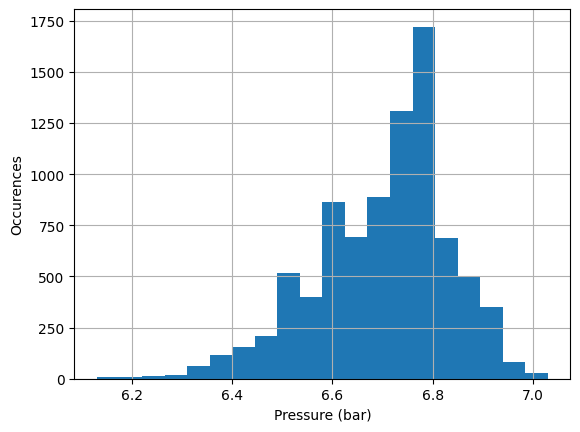

In [40]:
air_leader['Master.AE1 (Netzdruck)'].hist(bins=20)
plt.xlabel('Pressure (bar)')
plt.ylabel('Occurences')



Text(0, 0.5, 'Occurences')

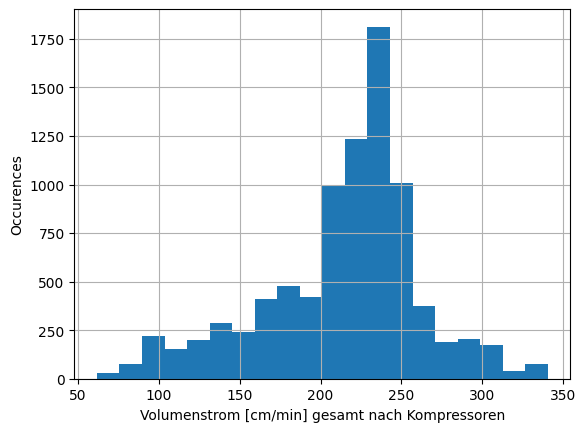

In [41]:
air_leader['Consumption'].hist(bins=20)
plt.xlabel('Volumenstrom [cm/min] gesamt nach Kompressoren')
plt.ylabel('Occurences')


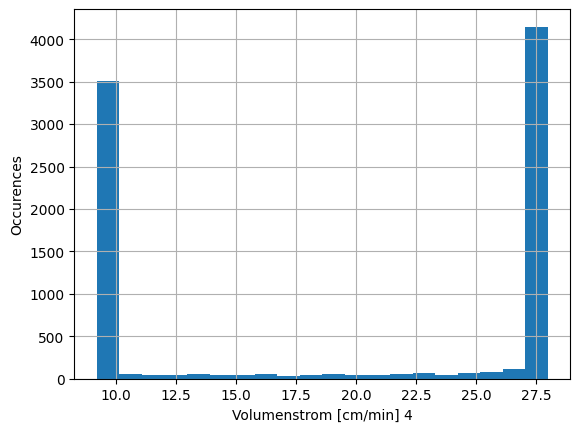

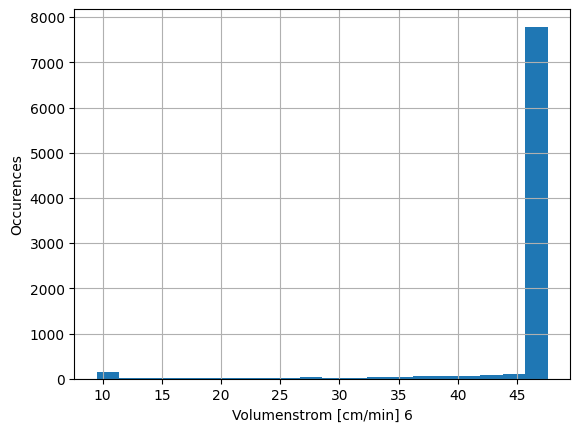

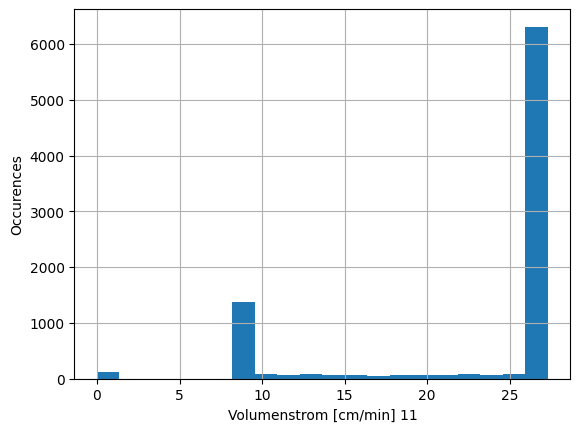

In [42]:
for c in [4,6,11]:
    air_leader['%s' %c + '.AE1'].hist(bins=20)
    plt.xlabel('Volumenstrom [cm/min] %s' %c)
    plt.ylabel('Occurences')
    plt.show()

### comparing 'seconds'

In [43]:
power_consumption['seconds'].head()

0     300.0
1     600.0
2     900.0
3    1200.0
4    1500.0
Name: seconds, dtype: float64

In [44]:
air_leader['seconds'].head()

0    14.0
1    24.0
2    34.0
3    44.0
4    54.0
Name: seconds, dtype: float64

In [45]:
air_flow_net['seconds'].head()

0     420.0
1    1320.0
2    2220.0
3    3120.0
4    4020.0
Name: seconds, dtype: float64

In [46]:
air_flow_net_precise['seconds'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: seconds, dtype: float64

In [47]:
air_flow_net_precise_full['seconds'].head()

124    120.0
208    240.0
215    240.0
249    300.0
316    420.0
Name: seconds, dtype: float64